<h1> Ensemble script for FATES-SP runs </h1>

This script will 

<ol>
<li>Clone github repo and move to CLM-FATES-SP pull request branchs
<li>Make a default 4x5 CLM-FATES-SP case
<li>Make an ensemble of CLM-FATES-SP cases 
<li>Generate an ensemble of parameter files with one at a time modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

<h4>n.b. 1. Most of the decisions here on compsets, FATES options, resolution, variables etc. are easy to modify. </h4>
<h4>n.b. 2. This notebook is also set up to wok with Cheyenne specific paths. Making it machine agnostic is tbd.</h4>

<h3>Set global variables and paths for ensemble analysis </h3>

In [1]:
#set global variables to pass into BASH commands. 

#Settings for the SP ensemble

sp=1
if(sp == 1):
    ctsmrepo='ctsmsept20'
    defcase='SPdefault'
    ens_directory='SPfates_ens'
    caseroot='spfates_01_n'
    paramsdir='param_files_sp'
    defbuildroot='/glade/scratch/'
    resub=0
    ncases=14
    ychoose =2009

else:
#Settings for the NOCOMP ensemble. 
#set global variables to pass into BASH commands. 
    sp=0
    ctsmrepo='ctsmsept20'
    defcase='SPdefault'
    ens_directory='NOCOMP_fates_ens'
    caseroot='nocomp_fates_01_n'
    paramsdir='param_files_sp'
    defbuildroot='/glade/scratch/'
    resub=2
    ncases=14
    ychoose =2009

<h3> Control variables for the analysis script.</h3>

In [2]:
dosubmit=0
forcenewcase=0
doanalysis=1

In [3]:
import os
notebookdr=os.getcwd() 

<h3>Clone CTSM repo, switch to SP pull request code.</h3>

In [4]:
%%bash -s "$ctsmrepo"
ctsmrepo=$1

cd /glade/work/$USER/
#go to git directory
if [[ -d "git" ]]
then
cd git/
else
mkdir git
cd git
fi

#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
else

#clone CTSM code
git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
./manage_externals/checkout_externals
cd src

#change CTSM code to SP branch. 
git remote add  rosie_ctsm_repo  https://github.com/rosiealice/ctsm
git fetch rosie_ctsm_repo
git checkout -b SP_api rosie_ctsm_repo/SP_api

#change FATES code to SP branch. 
cd fates
git remote add  rosie_fates_repo https://github.com/rosiealice/fates
git fetch rosie_fates_repo
git checkout -b fates_sp_sept rosie_fates_repo/fates_sp_sept
fi

<h3> Make a default FATES 4x5 case </h3>

In [5]:
%%bash -s "$ctsmrepo" "$defcase"

ctsmrepo=$1
defcase=$2

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem."
else
./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_CISM2%NOEVOLVE_SWAV_SIAC_SESP --res f45_f45_mg37  --run-unsupported
./case.setup
./case.build
fi

cd $casename

/glade/work/rfisher/git/ctsmsept20/cime/scripts
SPdefault exists on your filesystem.


<h3> Adjust settings of default case. </h3>

In [6]:
%%bash -s "$ctsmrepo" "$defcase" "$defbuildroot" "resub"

ctsmrepo=$1
defcase=$2
resub=$3
defbuildroot=$3
sp=$4
defbld=$defbuildroot$USER/$defcase/bld
echo $defbld
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts/$defcase

echo 'updating settings',$newcase
./xmlchange BUILD_COMPLETE=TRUE;
./xmlchange EXEROOT=$defbld;
./xmlchange CONTINUE_RUN=FALSE;
./xmlchange --id STOP_N --val 10;
./xmlchange --id RESUBMIT --val $resub;
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;


/glade/scratch/rfisher/SPdefault/bld
updating settings,
For your changes to take effect, run:
./case.build --clean-all
./case.build
For your changes to take effect, run:
./case.build --clean-all
./case.build


ERROR: Entry RESUBMIT was listed as type int but value '/glade/scratch/' is not valid int


<h3> Make Default user_nl_clm File </h3>

In [7]:
%%bash -s "$ctsmrepo" "$defcase" "$notebookdr" "$paramsdir"

ctsmrepo=$1
echo $ctsmrepo
defcase=$2
notebookdr=$3
paramsdir=$4
echo $paramsdir
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
cp  $defcase/user_nl_clm $notebookdr/$paramsdir/user_nl_clm_default
echo $notebookdr/$paramsdir/
cd $notebookdr/$paramsdir/

pftfilename_def=$notebookdr/$paramsdir

#echo use_fates_sp=.true. >> user_nl_clm_default
echo use_fates_nocomp=.true. >> user_nl_clm_default
echo use_fates_fixed_biogeog=.true. >> user_nl_clm_default
echo fates_paramfile=\'\pftfilename_default\' >> user_nl_clm_default

#cat  $notebookdr/$paramsdir/user_nl_clm_default

ctsmsept20
param_files_sp
/glade/work/rfisher/git/ctsmsept20/cime/scripts
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/


<h3> Make ensemble of cases.</h3>

In [8]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$forcenewcase"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=$6

echo $ncases
echo $caseroot
echo $ens_directory
echo $ctsmrepo

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd

if [[ -d "$ens_directory" ]]
then
echo "directory already exists"
else
mkdir $ens_directory
fi 

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  rm -rf $newcase 
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase   
  else
   echo 'making', $newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase 
    ./case.setup;
    cd ../../
  fi
  if [ $forcenewcase -eq 1 ]
  then
   echo 'force making', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    ./case.setup;
    cd ../../
  fi

  ((counter1++))
  done    


14
spfates_01_n
SPfates_ens
ctsmsept20
/glade/work/rfisher/git/ctsmsept20/cime/scripts
directory already exists
 new case already exists,SPfates_ens/spfates_01_n0
 new case already exists,SPfates_ens/spfates_01_n1
 new case already exists,SPfates_ens/spfates_01_n2
 new case already exists,SPfates_ens/spfates_01_n3
 new case already exists,SPfates_ens/spfates_01_n4
 new case already exists,SPfates_ens/spfates_01_n5
 new case already exists,SPfates_ens/spfates_01_n6
 new case already exists,SPfates_ens/spfates_01_n7
 new case already exists,SPfates_ens/spfates_01_n8
 new case already exists,SPfates_ens/spfates_01_n9
 new case already exists,SPfates_ens/spfates_01_n10
 new case already exists,SPfates_ens/spfates_01_n11
 new case already exists,SPfates_ens/spfates_01_n12
 new case already exists,SPfates_ens/spfates_01_n13
 new case already exists,SPfates_ens/spfates_01_n14


<h3> Create .nc version of current defualt file. I FAILED ATT THIS. NEEDS INPUT..</h3>
You currently have to do this step manually, by doing this in the terminal:

<i> cd /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/</i><br>
<i>ncgen -o fates_params_default.nc fates_params_default.cdl </i>

<h3> Make a directory for the parameter files to go in and copy default .nc parameter file there. </h3>

In [9]:
%%bash -s "$ctsmrepo" "$notebookdr"  "$paramsdir"
echo $1
ctsmrepo=$1
notebookdr=$2
paramsdir=$3
echo $ctsmrepo

cd $notebookdr
if [[ -d "$paramsdir" ]]
then
   cd $paramsdir
   echo "existing param firectory"
else 
    mkdir $paramsdir
    echo "made param firectory"
fi
pwd

cp /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/fates_params_default.nc fates_params_default.nc



ctsmsept20
ctsmsept20
existing param firectory
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp


<h3>Mpdify default parameter file</h3>

In [10]:
import netCDF4 as nc4
import sys
import os
import shutil

def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2)
       # print('replacing file: '+filename2)
    except:
        print('file does not yet exist: '+filename2)
    shutil.copyfile(filename1, filename2)


filename_template = notebookdr+'/'+paramsdir+'/fates_params_default.nc'

def def_pftfile(notebookdr, paramsdir,i,variable,delta):
    filename_out= notebookdr+'/'+paramsdir+'/fates_params_update_'+str(i)+'.nc'
    copy_clobber(filename_template,filename_out)

    fin = nc4.Dataset(filename_out, 'r+')
    print(filename_out)
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()
    
#1 fates_leaf_clumping_index +-10% (not above 1)
#2 fates_leaf_diameter +- 20%
#3 fates_leaf_stomatal_slope_ballberry +- 20%
#4 fates_leaf_vcmax25top +- 20%
#5 Fates_leaf_xl = +- 20%
#6 fates_rholvis=+-20-%
#7 Fates_smpsc=+-20%
#default    
def_pftfile(notebookdr, paramsdir,0,'fates_leaf_clumping_index',1.0)

    
def_pftfile(notebookdr, paramsdir,1,'fates_leaf_clumping_index',0.9)
def_pftfile(notebookdr, paramsdir,2,'fates_leaf_clumping_index',1.1)

def_pftfile(notebookdr, paramsdir,3,'fates_leaf_diameter',0.8)
def_pftfile(notebookdr, paramsdir,4,'fates_leaf_diameter',1.2)

def_pftfile(notebookdr, paramsdir,5,'fates_leaf_stomatal_slope_ballberry',0.8)
def_pftfile(notebookdr, paramsdir,6,'fates_leaf_stomatal_slope_ballberry',1.2)

def_pftfile(notebookdr, paramsdir,7,'fates_leaf_vcmax25top',0.8)
def_pftfile(notebookdr, paramsdir,8,'fates_leaf_vcmax25top',1.2)

def_pftfile(notebookdr, paramsdir,9,'fates_leaf_xl',0.8)
def_pftfile(notebookdr, paramsdir,10,'fates_leaf_xl',1.2)

def_pftfile(notebookdr, paramsdir,11,'fates_rholvis',0.8)
def_pftfile(notebookdr, paramsdir,12,'fates_rholvis',1.2)

def_pftfile(notebookdr, paramsdir,13,'fates_smpsc',0.8)
def_pftfile(notebookdr, paramsdir,14,'fates_smpsc',1.2)



/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_0.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_1.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_2.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_3.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_4.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_5.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_6.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_7.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_8.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_9.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_10.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp/fates_params_update_11.nc
/glade/u/home/rfisher/fate

<h3> Point each ensemble script at different parameter file </h3>

In [11]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$notebookdr"  "$paramsdir"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=1
notebookdir=$6
paramsdir=$7

unl=user_nl_clm
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
counter1=0
cd $ens_directory
#cat $notebookdir/$paramsdir/user_nl_clm_default
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  pftfilename=$notebookdir/$paramsdir/fates_params_update_$counter1.nc
  if [ -d $newcase ]
  then
   cd $newcase
   #get default parameter file
    cp $notebookdir/$paramsdir/user_nl_clm_default user_nl_clm
    sed -i "s|pftfilename_default|$pftfilename|g" user_nl_clm
    cd ../
  else
   echo 'no case', $newcase
  fi


  ((counter1++))
  done
cat $newcase/user_nl_clm

!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                             option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch cases
!                        (includ

<h3>Submit ensemble of cases</h3>

In [12]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$dosubmit" 

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6


if [ $dosubmit -eq 1 ]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts

counter1=0
cd $ens_directory
pwd
ls -l
while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    ./xmlchange CONTINUE_RUN=TRUE
    ./case.submit;
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

not submitting jobs


<h2>Analyse output</h2>

In [13]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs
import os.path

In [14]:

titles=['clumping_index -','clumping_index +','leaf_diameter -','leaf_diameter +',
           'stomatal_slope -','stomatal_slope +','vcmax25top -','vcmax25top +',
           'leaf_xl -','leaf_xl +','rholvis -','rholvis +',    
           'smpsc -','smpsc +' ]
output='/glade/scratch/rfisher/'
conv = 3600*24*365
yr='.clm2.h0.'

<h4>Default ensemble member</h4>

In [15]:

run=caseroot+str(0)
arc = output + 'archive/' + run + '/lnd/hist/'
# arc = output + run + '/run/'   
f2=(arc +run+yr+str(ychoose)+'-01.nc') 
print(f2)
if(os.path.isfile(f2)):
    dsdef = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
else:
    arc = output + run + '/run/'
    dsdef = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
print(arc)

/glade/scratch/rfisher/archive/spfates_01_n0/lnd/hist/spfates_01_n0.clm2.h0.2009-01.nc
/glade/scratch/rfisher/archive/spfates_01_n0/lnd/hist/


<h3>Make output figure directory</h3>

In [16]:
%%bash -s "$notebookdr"  
notebookdr=$2

cd $notebookdr
if [[ -d "figs" ]]
then
   echo "existing fig firectory"
else 
    mkdir figs
    echo "made fig firectory"
fi

existing fig firectory


<h3>Read in selected year of output data</h3>

1
2
3
4
5
6
7
8
9
10
11
12
13
14
figs/1pft_mmeangpp_spfates_01_n.png


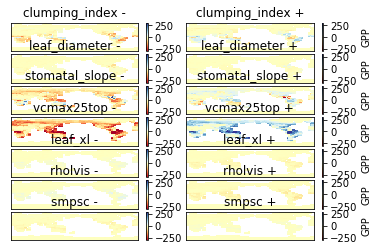

In [17]:
import time
if doanalysis ==1:
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 35]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
 
    for i in range(1,15):
        print(i)
        ax = fig.add_subplot(7, 2, i)     
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
       # arc = output + run + '/run/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
        else:
            arc = output + run + '/run/'
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
                 
        diff=np.multiply(np.mean(ds0.GPP,0),conv)-np.multiply(np.mean(dsdef.GPP,0),conv)
        plt1=diff.plot(cmap='RdYlBu') 
        plt1.set_clim(-300, 300)
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.canvas.draw()
        time.sleep(1)  
    fnmfig='figs/ensemble_GPP_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
figs/1pft_mmeanEFLX_LH_TOT_spfates_01_n.png


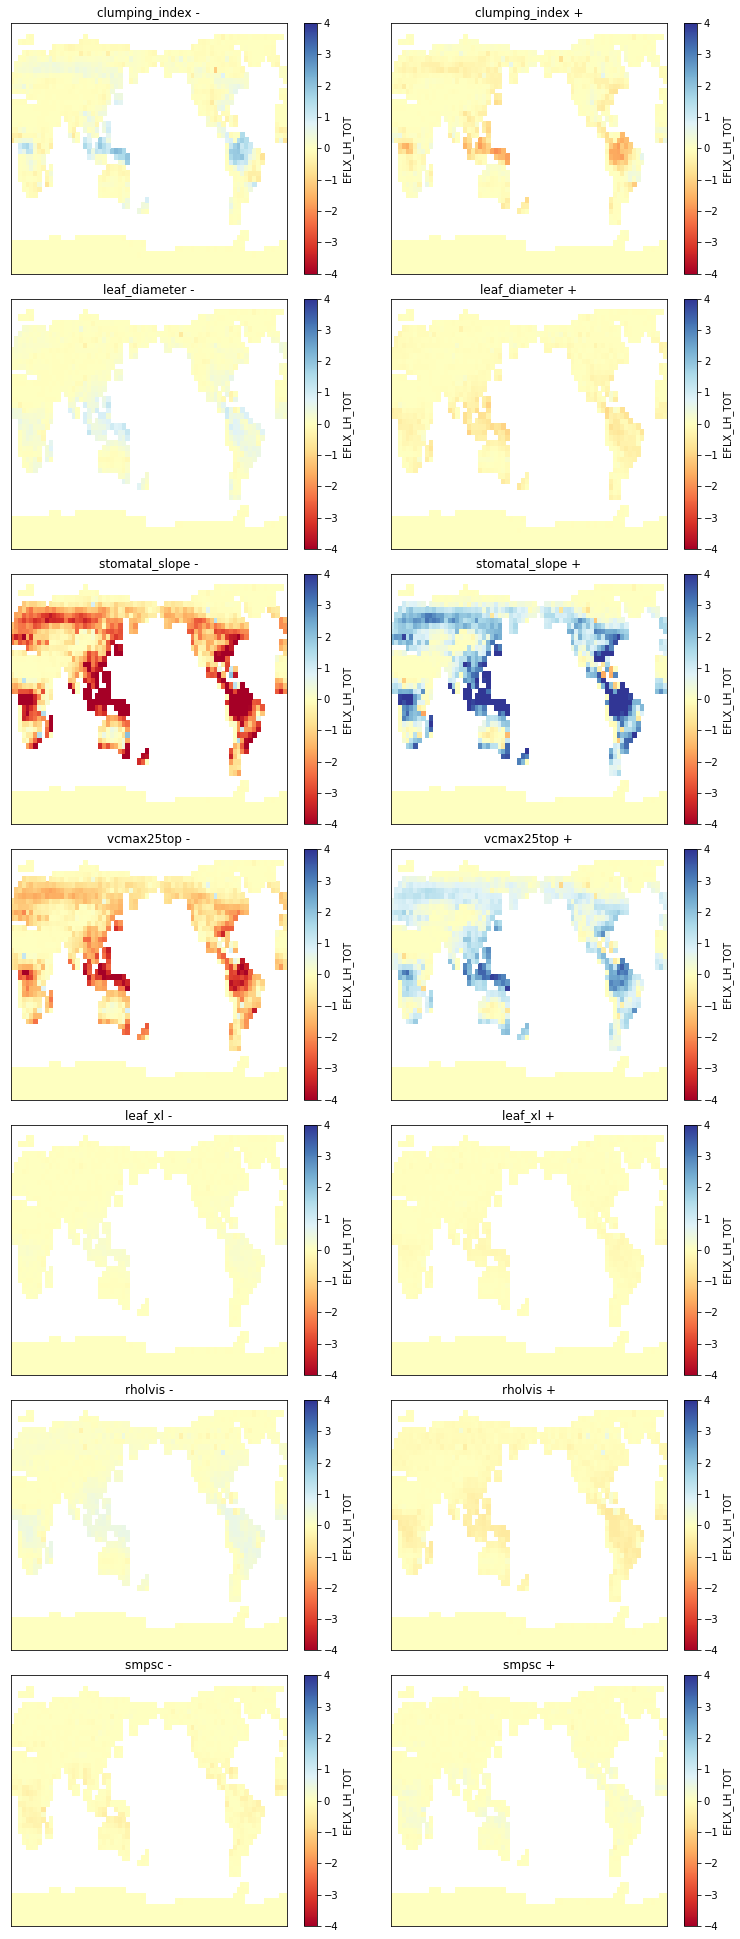

In [18]:
if doanalysis ==1:
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 35]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(1,15):
        print(i)
        ax = fig.add_subplot(7, 2, i)     
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
       # arc = output + run + '/run/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
        else:
            arc = output + run + '/run/'
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
                 
        diff=np.multiply(np.mean(ds0.EFLX_LH_TOT,0),1)-np.multiply(np.mean(dsdef.EFLX_LH_TOT,0),1)
        plt1=diff.plot(cmap='RdYlBu') 
        plt1.set_clim(-4, 4)
        ax.set_title(titles[i-1]) 
       # ax.set_title(title(i))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            #ax.get_title().set_visible(False)
        

    fnmfig='figs/ensemble_EFLX_LH_TOT_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
../figs/1pft_mmeanBTRAN_spfates_01_n.png


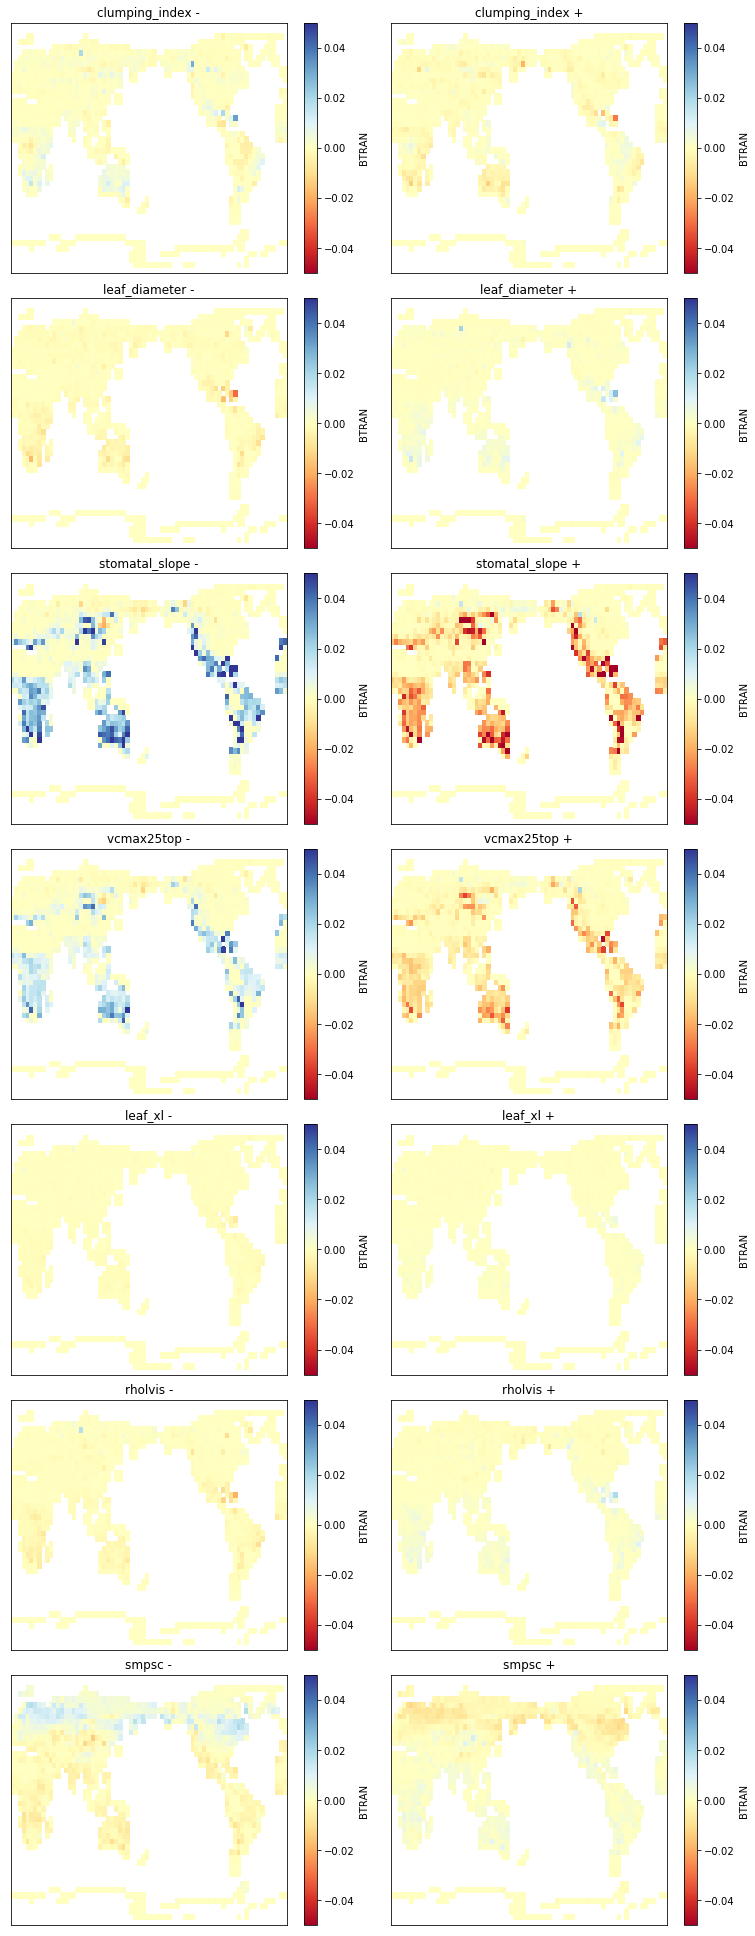

In [19]:
if doanalysis ==1:
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 35]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i in range(1,15):
        print(i)
        ax = fig.add_subplot(7, 2, i)     
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
       # arc = output + run + '/run/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
        else:
            arc = output + run + '/run/'
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
                 
        diff=np.multiply(np.mean(ds0.BTRAN,0),1)-np.multiply(np.mean(dsdef.BTRAN,0),1)
        plt1=diff.plot(cmap='RdYlBu') 
        plt1.set_clim(-0.05, 0.05)
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fnmfig='../figs/ensemble_BTRAN_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
../figs/1pft_mmeanELAI_spfates_01_n.png


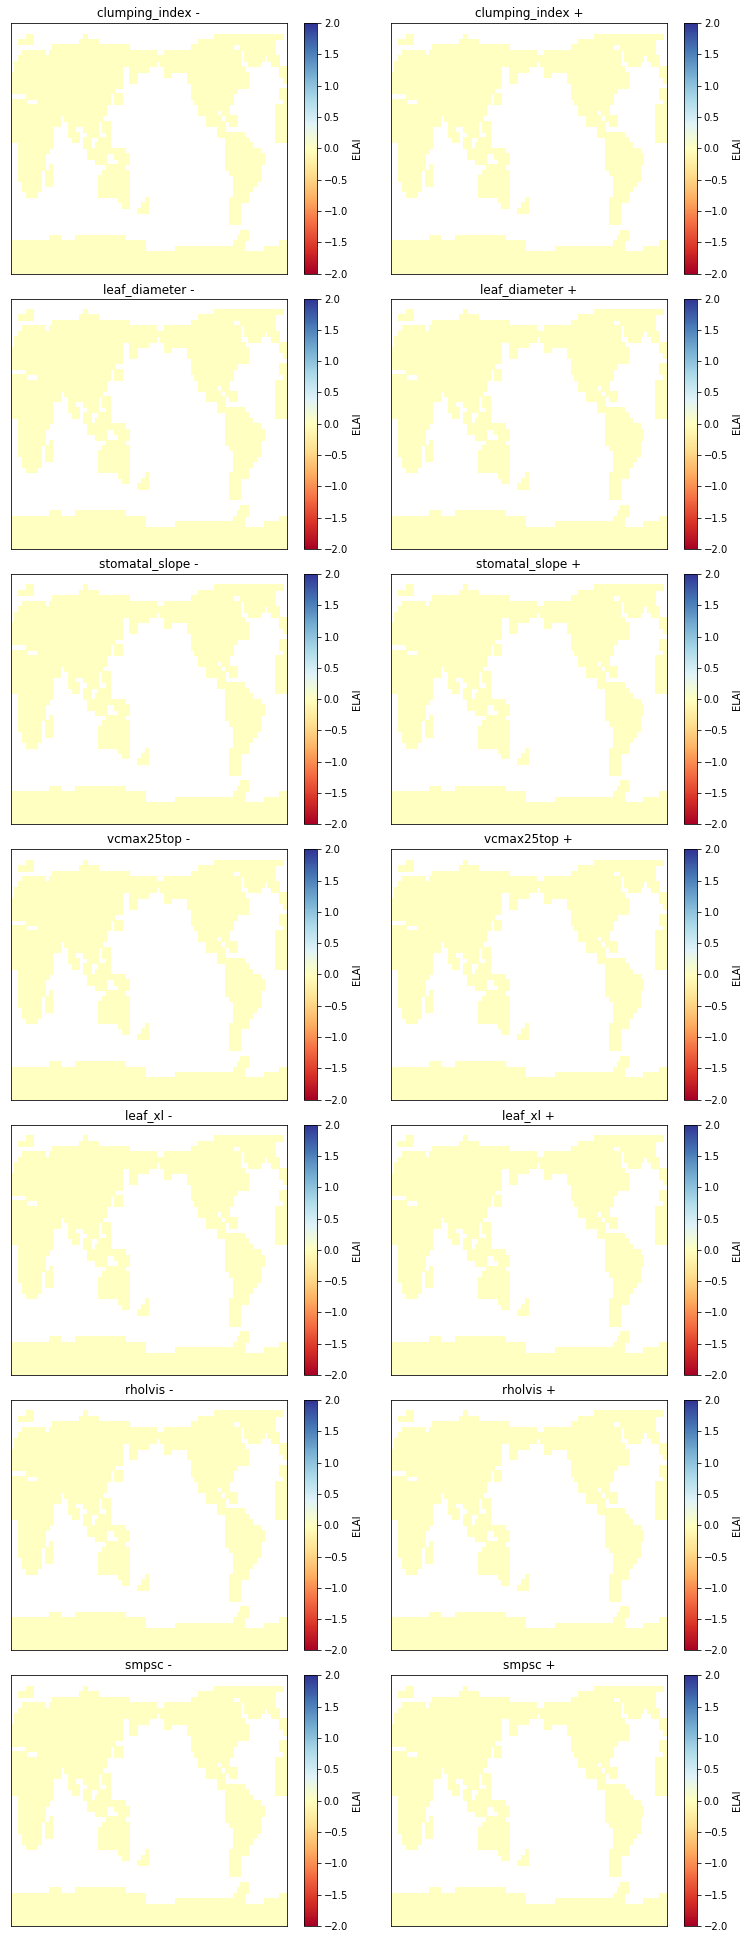

In [20]:
if doanalysis ==1:
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 35]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i in range(1,15):
        print(i)
        ax = fig.add_subplot(7, 2, i)     
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
       # arc = output + run + '/run/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
        else:
            arc = output + run + '/run/'
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
                 
        diff=np.multiply(np.mean(ds0.ELAI,0),1)-np.multiply(np.mean(dsdef.ELAI,0),1)
        plt1=diff.plot(cmap='RdYlBu') 
        plt1.set_clim(-2, 2)
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.canvas.draw()
        time.sleep(1)  
    fnmfig='../figs/ensemble_ELAI_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)


../figs/default_GPP_spfates_01_n.png


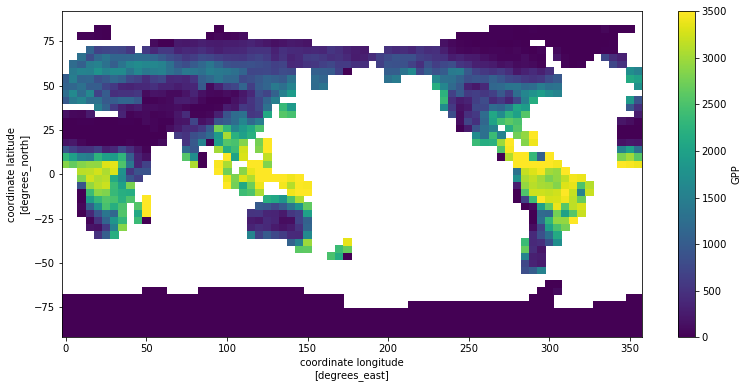

In [24]:
if doanalysis ==1:
    
   # fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 6]
    #fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax=np.multiply(np.mean(dsdef.GPP,0),conv).plot()
    ax.set_clim(-0, 3500)
 
    fnmfig='../figs/default_GPP_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)

../figs/default_def0_spfates_01_n.png


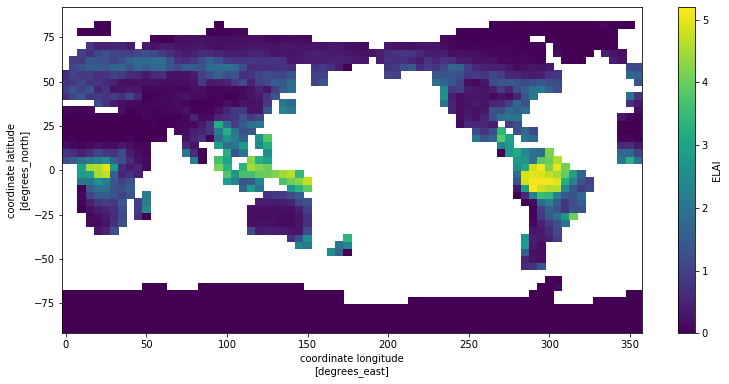

In [23]:
if doanalysis ==1:
    
   # fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 6]
    #fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax=np.mean(dsdef.ELAI,0).plot()
   # ax.set_clim(-0, 3500)
 
    fnmfig='../figs/default_def0_'+caseroot+'.png'
    print(fnmfig)
    plt.savefig(fnmfig)